# Experiment - Generation Prediction
* StellarAlgo Data Science
* April 14, 2023
* Grant Donst, Peter Morrison

In [29]:
import pandas as pd
import os
import numpy as np

from data_sci_toolkit.aws_tools import redshift_tools
from pycaret.classification import *
from agefromname import GenerationFromName
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

0it [00:00, ?it/s]


# Load in Data

Running query to gather first name, gender, and other possible features from cohortcustomer, cohortmerch, and cohortconcession

Used: https://us-east-1.quicksight.aws.amazon.com/sn/accounts/040358163756/dashboards/a1d176c8-9169-4591-9d5d-4c5025df6ad7?directory_alias=stellaralgo-quicksights&qs-nonce=IYDdz6szxXlvbhvZBqN7h2KcTPWzpOOBh5ceoklbGXs%3D#

To determine which teams have good generation data (basically just the NFL teams and USL-Locomotive)

In [20]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is not null 
and cc.namefirst is not null;
"""

cluster = "prod-app"
database = "stlrnflvikings"

In [21]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


In [22]:
df_generation = df

# Pre-Processing

We will preprocess the data, so we can have a predicted score of their ethnicity and clean other data.

In [23]:
df_generation["gender"].value_counts()

Male      2098546
Female    1070932
U          192078
Name: gender, dtype: int64

In [24]:
df_generation = df_generation[df_generation["gender"] != "U"]

In [25]:
df_generation["gender"] = np.where(df_generation['gender'] == "Male", "m", "f")

In [27]:
df_generation["gender"].value_counts()

m    2098546
f    1070932
Name: gender, dtype: int64

In [30]:
generation_from_name = GenerationFromName()
df_generation['gen_pred'] = df_generation.progress_apply(lambda x: generation_from_name.argmax(x.namefirst.title(), x.gender), axis=1)

2002it [07:13,  4.62it/s]


KeyboardInterrupt: 

In [21]:
df_generation.head()

,gender,dimcustomermasterid,lkupclientid,namefirst,namelast,income,education,occupation,monetary_tier_overall,engagementbucket,ethnicity,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic
0,Male,330718,5,Jamie,Mcgowan,35000,Completed High School,None,None,No Data,White or Other,77.96,18.69,0.35,0.40,1.28,1.32
1,Male,330722,5,Jordan,Gilbreth,124999,Completed Graduate School,Professional / Technical,None,No Data,Asian,92.40,(S),(S),0.92,1.84,3.57
2,Male,330728,5,Jason,Hamilton,35000,Completed High School,None,None,No Data,White or Other,72.79,22.65,0.44,0.78,1.73,1.61
3,Male,330729,5,Jonathan,Lanz,45000,Completed College,None,1,Dormant,White or Other,86.51,3.30,1.13,0.35,0.78,7.94
4,Female,330734,5,Jeanne,Norman,35000,Completed High School,None,None,No Data,White or Other,71.58,24.13,0.42,0.61,1.71,1.54


# Train Model

In [52]:
setup(
    data=df_ethnicity,
    target='ethnicity',
    train_size=0.85,
    data_split_shuffle=True,
    #silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription", "namelast", "occupation", "income"],
    numeric_features=["pctwhite", "pctblack", "pctapi", "pctaian", "pct2prace", "pcthispanic"]
)

In [53]:
model_matrix = compare_models(
    fold=2,
    include= ["catboost"]
)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:22:56
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [54]:
best_model = create_model(model_matrix, fold=2);

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:29:46
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8950,0.8008,0.8950,0.8730,0.8717,0.5278,0.5767
1,0.8969,0.8007,0.8969,0.8761,0.8746,0.5386,0.5860
Mean,0.8959,0.8008,0.8959,0.8745,0.8732,0.5332,0.5813
Std,0.0009,0.0001,0.0009,0.0015,0.0015,0.0054,0.0047


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8950,0.8008,0.8950,0.8730,0.8717,0.5278,0.5767
1,0.8969,0.8007,0.8969,0.8761,0.8746,0.5386,0.5860
Mean,0.8959,0.8008,0.8959,0.8745,0.8732,0.5332,0.5813
Std,0.0009,0.0001,0.0009,0.0015,0.0015,0.0054,0.0047


In [55]:
#best_model = tune_model(best_model)

In [56]:
final_model = finalize_model(best_model)

In [57]:
df_ethnicity.groupby(["occupation", "ethnicity"]).size()

occupation                   ethnicity     
Administration / Managerial  Asian              2196
                             Black              1881
                             Hispanic           4192
                             White or Other    70156
Clerical / White Collar      Asian              3643
                                               ...  
Self Employed - Student      White or Other      159
Student                      Asian              1310
                             Black              1069
                             Hispanic           1813
                             White or Other    23017
Length: 101, dtype: int64

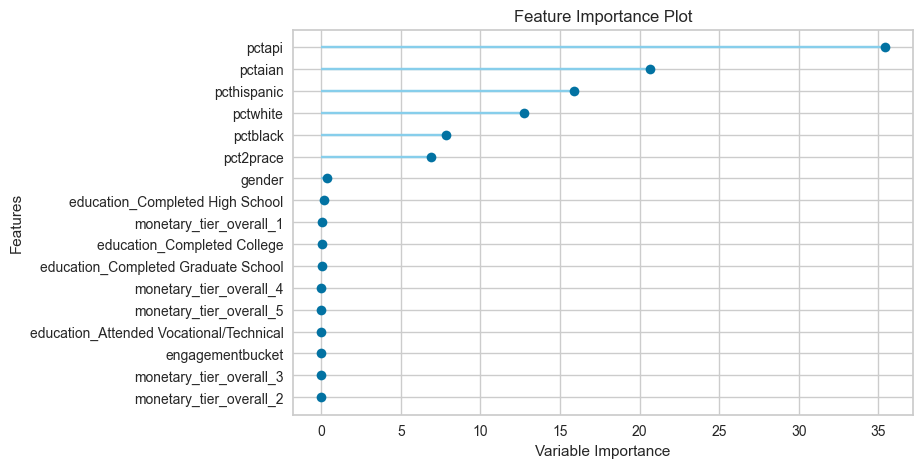

In [58]:
plot_model(best_model, plot="feature_all")